In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
import random
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# TONDUR, EngSpDist_K1, EngSpDist_K2, MILEAGE

In [30]:
# read the data
df = pd.read_csv('./data/logged_transformed_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.shape

(5777, 16)

In [31]:
df.head()

,TONDUR,EngSpDist_K1,EngSpDist_K2,EngSpDist_K3,EngSpDist_K4,EngSpDist_K5,EngSpDist_K6,EngSpDist_K7,AmbTempDist_K5,AmbTempDist_K6,AmbTempDist_K7,AmbTempDist_K8,AmbTempDist_K9,AmbTempDist_K10,MILEAGE,LABEL
0,14.038220,12.386195,13.002472,12.346563,9.849897,8.147491,7.397562,6.619273,2.397895,5.762051,6.033086,5.049856,0.000000,0.000000,10.463360,0
1,14.613686,13.674723,13.667726,11.945884,9.450003,7.967869,6.859195,6.148255,2.708050,6.171701,6.173786,5.123964,0.693147,0.000000,9.613135,0
2,15.049144,13.620402,14.485669,12.812301,10.168882,7.281799,5.477300,4.527209,1.945910,6.517671,6.901737,5.568345,1.098612,0.000000,10.537044,0
3,13.329598,11.841770,12.250756,11.573650,9.223740,7.014724,5.445443,4.412798,0.000000,5.135798,5.690359,4.727388,1.098612,0.000000,8.861492,0
4,14.576953,13.589420,13.500192,12.399762,9.494737,7.772963,6.705272,5.835103,2.564949,5.883322,6.621406,5.438079,1.098612,0.693147,9.887409,0


In [36]:
df_features_selected = df[['TONDUR', 'EngSpDist_K1', 'EngSpDist_K2', 'MILEAGE', 'LABEL']]

In [37]:
X = df_features_selected.drop(['LABEL'], axis=1).values
y = df_features_selected['LABEL'].values
print(X.shape, y.shape)

(5777, 4) (5777,)


For the modeling, baseline needs to established in order to evaluate the performance of the model. For simplicity, I will only consider models from three types: **Linear**, **Non-Linear**, **discriminative algorithm** and **Ensemble**. I will also consider f1 score as a metric for baseline to get the initial feel of the model performance due to high imbalance dataset classes, i.e., ***DAMAGE*** and ***NO_DAMAGE*** are equally important.

### Baseline without upsampling, feature selection (RF, Perm method), and hyperparameters tuning 


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline

In [39]:
# prepare configuration for cross validation test harness
seed = 7
stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=seed)
def model_evaluation(models, X, y):
    results = []
    names = []
    scoring = 'f1'
    # evaluate each model in turn
    for name, model in models:
        cv_results = model_selection.cross_validate(model, X, y, cv=stratified_kfold, scoring=scoring, return_train_score=True)
        print("Model:", name)
        print("Trainig Mean (Std.) Score:", np.mean(cv_results['train_score']), np.std(cv_results['train_score']))
        print("Testing Mean (Std.) Score:", np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
        results.append(cv_results['test_score'])
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Models Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
def model_evaluation_upsample(pipline, param_grid, X_train, y_train, X_test, y_test):
    
    
   
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='f1',
                               cv=stratified_kfold,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    


The following results show that the best performing model is **Random Forest** this task, however, it seems that it overfits but not as much as **Decision Treest** as DTs are known for overfitting. For **Logistic Regression** it's approximately close to Random Forest, i.e., average accuracy across 10-folds is 0.94 with small standard deviation(0.006), in terms of performance, but less prone to overfitting. 

Model: LR
Trainig Mean (Std.) Score: 0.28621525808676546 0.014999373673251623
Testing Mean (Std.) Score: 0.28204688510722997 0.0975208547294451
LR: 0.282047 (0.097521)
Model: DT
Trainig Mean (Std.) Score: 1.0 0.0
Testing Mean (Std.) Score: 0.2805077951926691 0.10383304009948793
DT: 0.280508 (0.103833)
Model: RF
Trainig Mean (Std.) Score: 0.9995402298850575 0.0009195402298850741
Testing Mean (Std.) Score: 0.2845691745107962 0.06783648962931443
RF: 0.284569 (0.067836)
Model: SVC
Trainig Mean (Std.) Score: 0.0 0.0
Testing Mean (Std.) Score: 0.0 0.0
SVC: 0.000000 (0.000000)


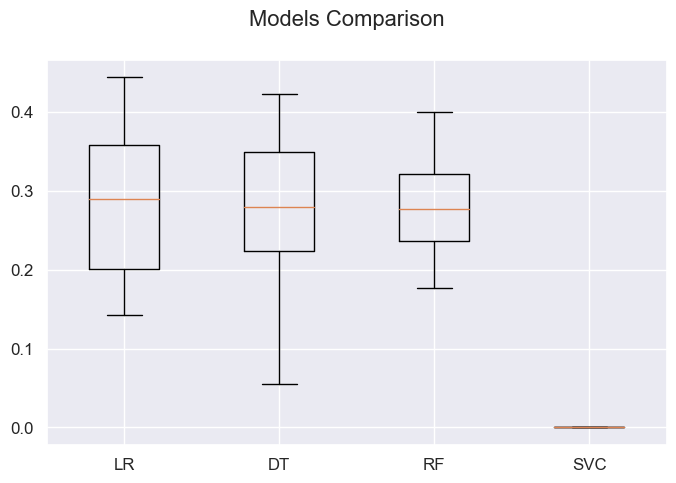

In [41]:

# prepare models
models = []
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC(kernel='rbf')
models.append(('LR', lr))
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('SVC', svc))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

model_evaluation(models, X_train, y_train)

As for the baselines, we will consider Logistic Regression (LR) and Random Forest (RF) models that are trained without upsampling, feature selection and hyperparameter tuning. 

### Upsampling but no feature selection and hyperparameter tuning.
In the following blocks, upsampling will be applied to compare the outcomes of the model, and we will accuracy as a baseline metric to compare the outcome with baseline models.\
We will consider **SMOTE (Synthetic Minority Oversampling TEchnique)** for this task, as smote is less prone to overfitting as compared to other techniques, e.g., oversampling with replacement. But it is **important** to upsample the data after splitting to avoid **information leakage**.

The following block of cells pass the **imblearn pipeline** as an argument to the model evaluation. The results show that **Random Forest** outperforms the 

In [42]:
from imblearn.over_sampling import SMOTE
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', lr]])

param_grid = {}
model_evaluation_upsample(pipeline, param_grid, X_train, y_train, X_test, y_test)

Cross-validation score: 0.34697585360508737
Test score: 0.37092731829573933


In [43]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', rf]])

param_grid = {}
model_evaluation_upsample(pipeline, param_grid, X_train, y_train, X_test, y_test)

Cross-validation score: 0.345936952504965
Test score: 0.38405797101449274


In [44]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', svc]])

param_grid = {}
model_evaluation_upsample(pipeline, param_grid, X_train, y_train, X_test, y_test)

Cross-validation score: 0.3334958437357526
Test score: 0.36190476190476184


In [20]:
from sklearn.model_selection import RandomizedSearchCV

In [110]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [111]:
rf_random = RandomizedSearchCV(estimator = rf,

param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, scoring='f1', n_jobs = -1)
rf_random.fit(X_train_sampled,y_train_sampled)

# this prints the contents of the parameters in the random grid
print ('Random grid: ', random_grid, '\n')

# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}  



In [112]:
from sklearn.metrics import classification_report
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1351
           1       0.40      0.48      0.44        94

    accuracy                           0.92      1445
   macro avg       0.68      0.71      0.70      1445
weighted avg       0.93      0.92      0.92      1445



In [113]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
oversample = SMOTE()
X_train_sampled, y_train_sampled = oversample.fit_resample(X_train, y_train)
grid_search = GridSearchCV(rf,
                           param_grid=param_grid,
                          scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1, 
                          verbose=10)
grid_search.fit(X_train_sampled, y_train_sampled)
print(grid_search.best_estimator_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=25)


In [114]:
best_random = grid_search.best_estimator_
y_pred = best_random.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1351
           1       0.28      0.81      0.41        94

    accuracy                           0.85      1445
   macro avg       0.63      0.83      0.66      1445
weighted avg       0.94      0.85      0.88      1445

